In [22]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [23]:
set.seed(123)
players<-read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


In [24]:
set.seed(123)
players<-players|>
select(subscribe, played_hours, Age)|>
filter(!is.na(Age), !is.na(played_hours))
players

subscribe,played_hours,Age
<lgl>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
⋮,⋮,⋮
TRUE,0.0,20
TRUE,0.0,17
FALSE,0.3,22


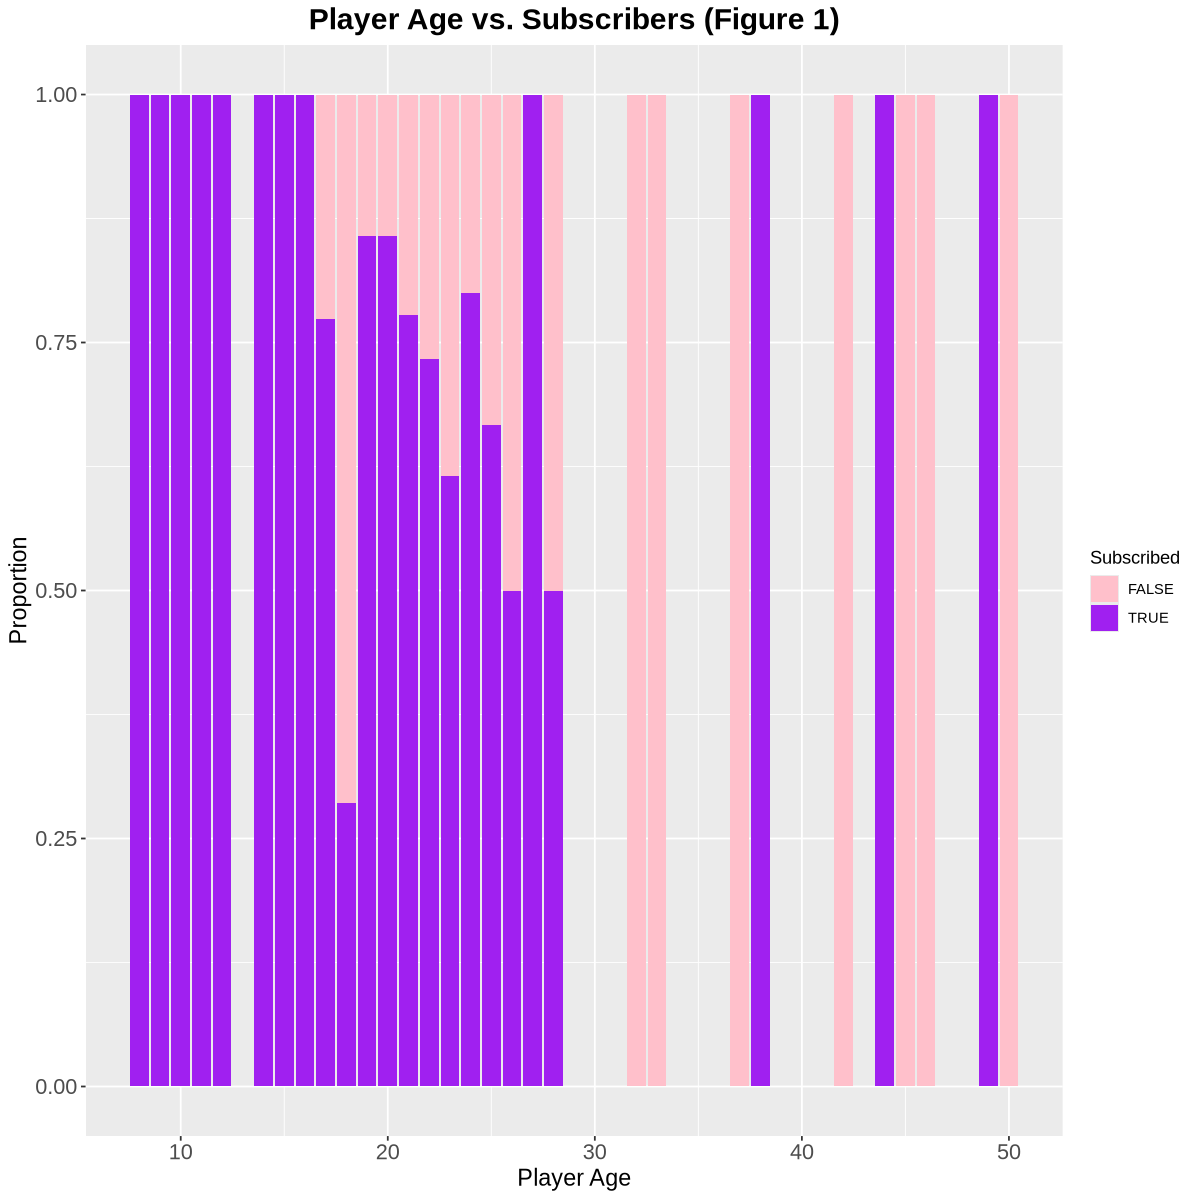

In [25]:
set.seed(123)
options(repr.plot.width = 10, repr.plot.height = 10) 
player_experience_plot<-players|>
ggplot(aes(x=Age, fill=subscribe))+
geom_bar(position="fill")+
labs(x="Player Age", y="Proportion", fill="Subscribed")+
scale_fill_manual(values = c("TRUE" = "purple", "FALSE" = "pink")) +
ggtitle("Player Age vs. Subscribers (Figure 1)")+
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
player_experience_plot

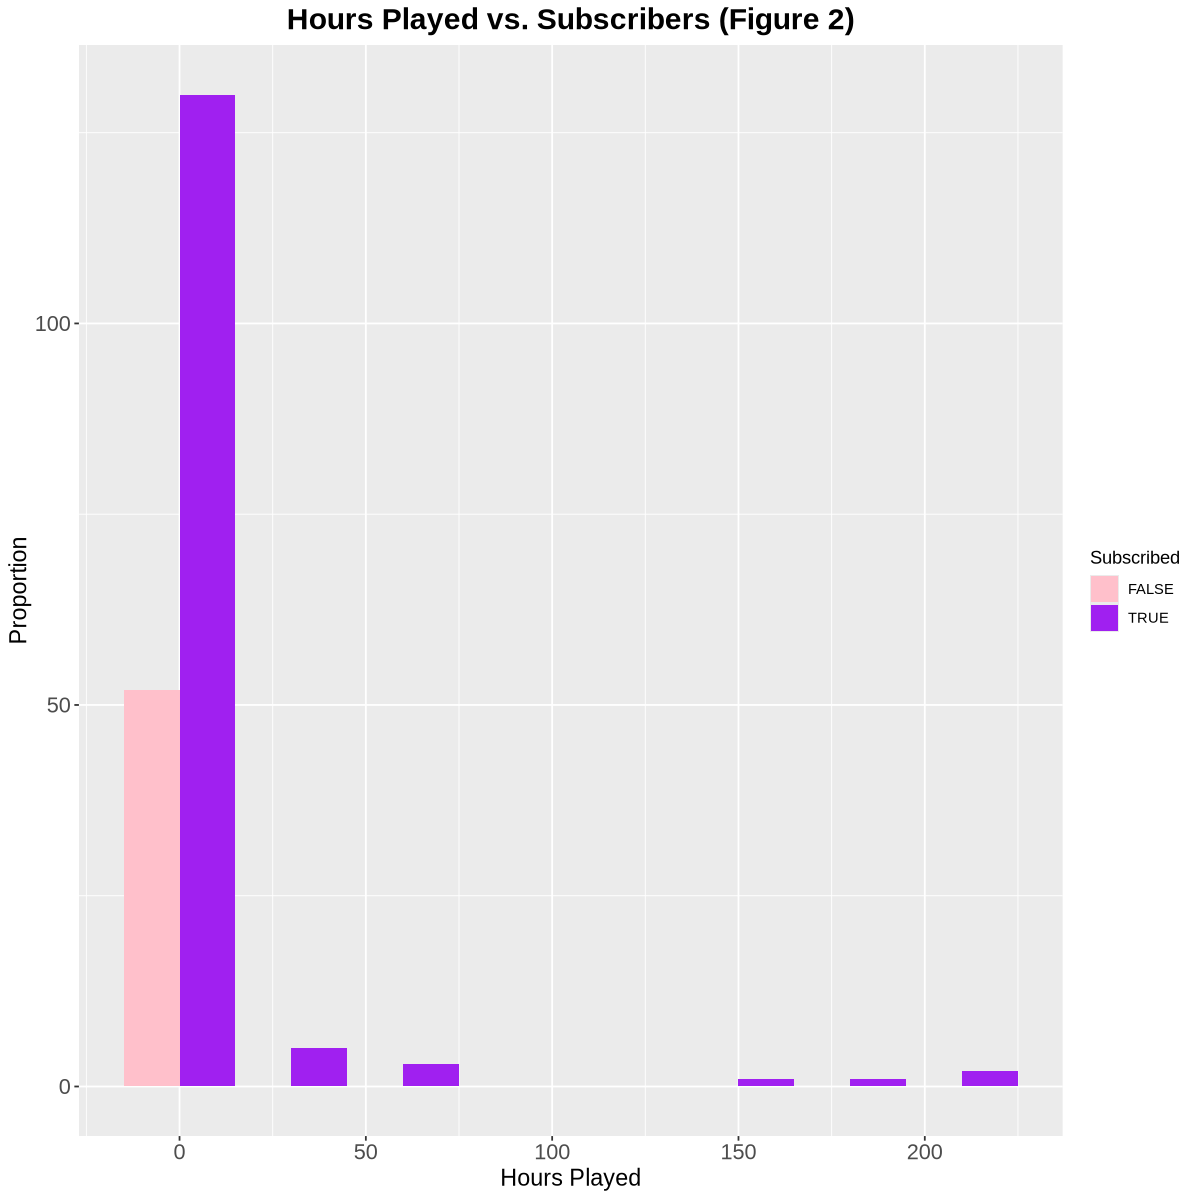

In [26]:
set.seed(123)
options(repr.plot.width = 10, repr.plot.height = 10) 
hours_played_plot<-players|>
ggplot(aes(x=played_hours, fill=subscribe))+
geom_histogram(position="dodge", binwidth=30)+
labs(x="Hours Played", y="Proportion", fill="Subscribed")+
scale_fill_manual(values = c("TRUE" = "purple", "FALSE" = "pink")) +
ggtitle("Hours Played vs. Subscribers (Figure 2)")+
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
hours_played_plot

In [27]:
set.seed(123)
players <- players|>
mutate(subscribe = as_factor(subscribe))
players

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
⋮,⋮,⋮
TRUE,0.0,20
TRUE,0.0,17
FALSE,0.3,22


In [28]:
set.seed(123)
data_split<-initial_split(players, prop = 0.8, strata = subscribe)
data_split
training_data<-training(data_split)
training_data
testing_data<-testing(data_split)
testing_data

<Training/Testing/Total>
<154/40/194>

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,22
FALSE,0.1,17
FALSE,0.0,23
FALSE,0.0,33
FALSE,1.4,25
⋮,⋮,⋮
TRUE,0.8,22
TRUE,32.0,22
TRUE,0.1,44


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,3.8,17
FALSE,0.0,17
FALSE,0.0,21
TRUE,48.4,17
TRUE,0.3,8
⋮,⋮,⋮
TRUE,0.4,17
FALSE,0.2,17
TRUE,0.0,17


In [29]:
set.seed(123)
subscribe_recipe<-recipe(subscribe~Age+played_hours, data=training_data)|>
step_scale(all_predictors())|>
step_center(all_predictors())
subscribe_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [30]:
set.seed(123)
subscribe_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
set_engine("kknn")|>
set_mode("classification")
subscribe_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [31]:
set.seed(123)
subscribe_fit<-workflow()|>
add_recipe(subscribe_recipe)|>
add_model(subscribe_spec)|>
fit(data=training_data)
subscribe_fit

Warning message:
“tune samples were requested but there were 154 rows in the data. 149 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2662338
Best kernel: rectangular
Best k: 149

In [32]:
set.seed(123)
subscribe_vfold<-vfold_cv(training_data, v = 5, strata = subscribe)
subscribe_vfold

Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 122, 123, 124

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NUL

In [33]:
set.seed(123)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

subscribe_resample_fit<-workflow()|>
add_recipe(subscribe_recipe)|>
add_model(subscribe_spec)|>
tune_grid(resamples=subscribe_vfold, grid=k_vals)|>
collect_metrics()
subscribe_resample_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4800134,5,0.02853938,Preprocessor1_Model01
1,roc_auc,binary,0.5247365,5,0.02790451,Preprocessor1_Model01
2,accuracy,binary,0.4866801,5,0.02853859,Preprocessor1_Model02
2,roc_auc,binary,0.5518198,5,0.03405302,Preprocessor1_Model02
3,accuracy,binary,0.5449731,5,0.01988937,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,roc_auc,binary,0.5817056,5,0.05773320,Preprocessor1_Model08
9,accuracy,binary,0.6365726,5,0.04651066,Preprocessor1_Model09
9,roc_auc,binary,0.5423968,5,0.05159371,Preprocessor1_Model09


In [34]:
set.seed(123)
accuracy <- subscribe_resample_fit |> 
       filter(.metric=="accuracy")
accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4800134,5,0.02853938,Preprocessor1_Model01
2,accuracy,binary,0.4866801,5,0.02853859,Preprocessor1_Model02
3,accuracy,binary,0.5449731,5,0.01988937,Preprocessor1_Model03
4,accuracy,binary,0.5256183,5,0.02300091,Preprocessor1_Model04
5,accuracy,binary,0.5780780,5,0.03435795,Preprocessor1_Model05
6,accuracy,binary,0.5711962,5,0.04408481,Preprocessor1_Model06
7,accuracy,binary,0.5845296,5,0.02461755,Preprocessor1_Model07
8,accuracy,binary,0.5845296,5,0.02461755,Preprocessor1_Model08
9,accuracy,binary,0.6365726,5,0.04651066,Preprocessor1_Model09


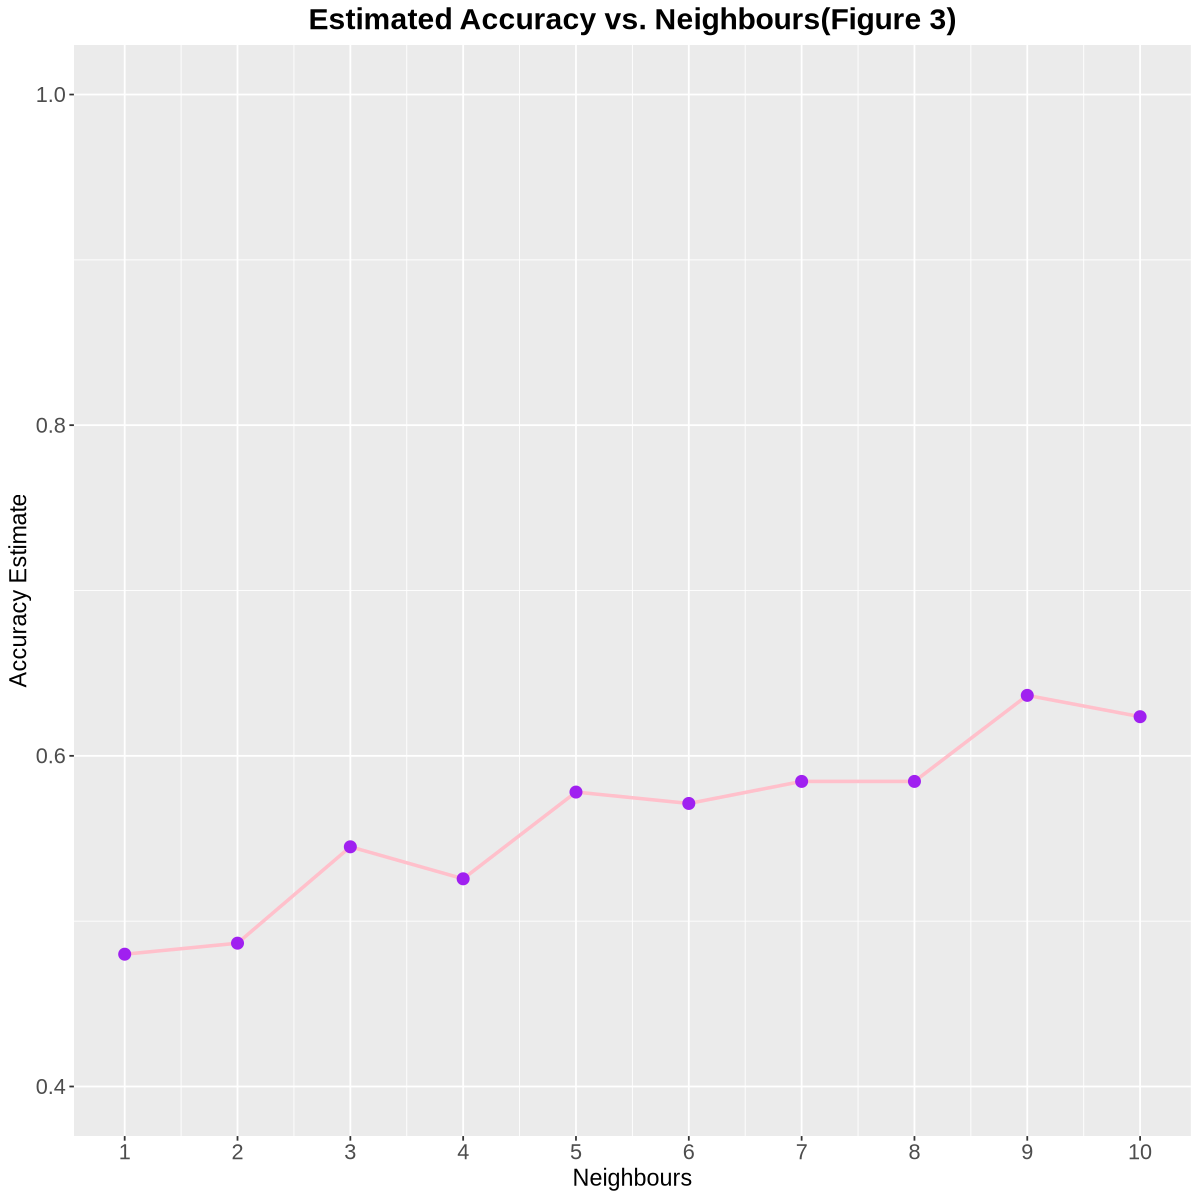

In [35]:
set.seed(123)
accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
geom_line(color = "pink", linewidth = 1) +
geom_point(size = 3, color = "purple") +
labs(x = "Neighbours", y = "Accuracy Estimate") +
scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
scale_y_continuous(limits = c(0.4, 1.0)) +
ggtitle("Estimated Accuracy vs. Neighbours(Figure 3)")+
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
accuracy_versus_k

In [36]:
set.seed(123)
best_k <- accuracy |>
  slice_max(mean, n = 1)
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.6365726,5,0.04651066,Preprocessor1_Model09


In [37]:
set.seed(123)
best_k_spec<-nearest_neighbor(weight_func="rectangular", neighbors=9)|>
set_engine("kknn")|>
set_mode("classification")
best_k_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 9
  weight_func = rectangular

Computational engine: kknn 


In [38]:
set.seed(123)
best_k_fit<-workflow()|>
add_recipe(subscribe_recipe)|>
add_model(best_k_spec)|>
fit(data=training_data)
best_k_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4025974
Best kernel: rectangular
Best k: 9

In [39]:
set.seed(123)
player_predictions=predict(best_k_fit, testing_data)|>
bind_cols(testing_data)
player_predictions

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,3.8,17
FALSE,FALSE,0.0,17
TRUE,FALSE,0.0,21
TRUE,TRUE,48.4,17
TRUE,TRUE,0.3,8
⋮,⋮,⋮,⋮
TRUE,TRUE,0.4,17
TRUE,FALSE,0.2,17
FALSE,TRUE,0.0,17


In [40]:
set.seed(123)
player_metrics <-player_predictions|>
metrics(truth = subscribe, estimate = .pred_class)
player_metrics
metrics_formatted <-player_metrics|>
mutate(.estimate = percent(.estimate, accuracy = 0.1))
metrics_formatted

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7250000
kap,binary,0.2903226


.metric,.estimator,.estimate
<chr>,<chr>,<chr>
accuracy,binary,72.5%
kap,binary,29.0%


In [41]:
set.seed(123)
player_mat<-player_predictions|>
conf_mat(truth=subscribe, estimate = .pred_class)
player_mat

          Truth
Prediction FALSE TRUE
     FALSE     5    5
     TRUE      6   24